In [1]:
import numpy as np
from process_nwb.linenoise_notch import apply_linenoise_notch
from process_nwb.resample import resample
from ecog.signal_processing import resample as resample2
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine

In [11]:
dt = 100.00 # seconds
rate = 1000. # Hz
df = 0.
t = np.linspace(0, dt, int(dt * rate))
t = np.tile(t[:, np.newaxis], (1, 5))
n_harmonics = int((rate / 2) // 60)

X = np.zeros_like(t)
for ii in range(n_harmonics):
    X += np.sin(2 * np.pi * (ii + 1) * (60. + df) * t)
X += np.random.randn(*X.shape) / 10.
X /= abs(X).max()
X += 5

In [12]:
X.shape

(100000, 5)

In [13]:
Xp = apply_linenoise_notch(X, rate, fft=True)

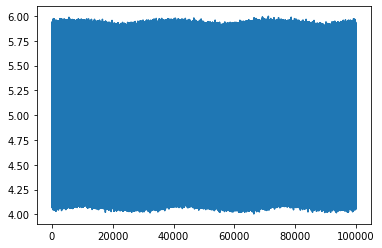

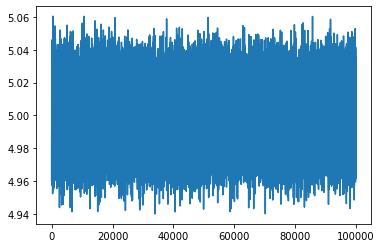

In [14]:
plt.plot(X[:, 0])
plt.figure()
plt.plot(Xp[:, 0])

In [15]:
Xds = resample(X, rate / 2., rate)
Xds2 = resample2(X, rate / 2., rate, axis=0)

here
vals [[-4.85168827+3.19339381j -2.93217389-1.34119826j -1.43245244+2.69794034j
  -5.66731124-7.05267569j -2.94363257+3.03037157j]]
[254984.11663731+0.j 254996.917844  +0.j 255000.02334309+0.j
 254978.17115529+0.j 254987.11646934+0.j]


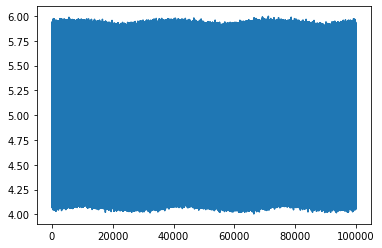

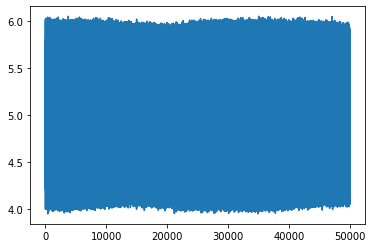

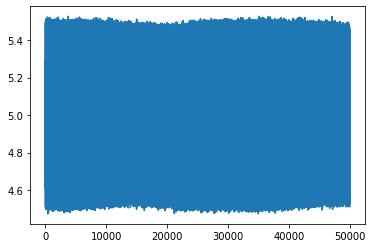

In [16]:
plt.plot(X[:, 0])
plt.figure()
plt.plot(Xds[:, 0])
plt.figure()
plt.plot(Xds2[:, 0])

In [2]:
dt = 50. # seconds
rate = 400. # Hz
t = np.linspace(0, dt, int(dt * rate))
t = np.tile(t[:, np.newaxis], (1, 5))
freqs = np.linspace(1, 20.1, 5.33)

X = np.zeros_like(t)
for f in freqs:
    X += np.sin(2 * np.pi * f * t)
    
X += 2

new_rate = 211. # Hz
t = np.linspace(0, dt, int(dt * new_rate))
t = np.tile(t[:, np.newaxis], (1, 5))
X_new_rate = np.zeros_like(t)
for f in freqs:
    X_new_rate += np.sin(2 * np.pi * f * t)
    
X_new_rate += 2

Xds = resample(X, new_rate, rate)
Xds2 = resample2(X, new_rate, rate, axis=0)

/home/jesse/anaconda3/envs/spectrumregression/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """
/home/jesse/Development/process_ecog/ecog/signal_processing/resample_clone.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/jesse/Development/process_ecog/ecog/signal_processing/resample_clone.py:115: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]


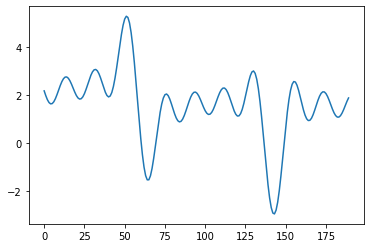

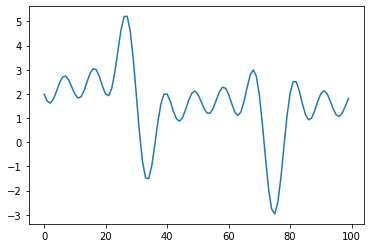

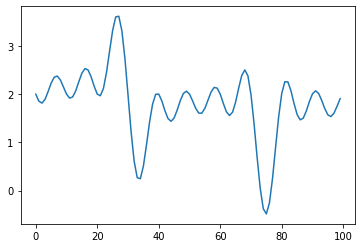

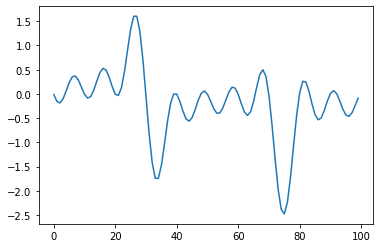

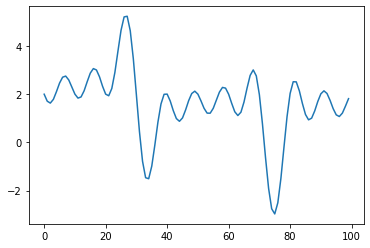

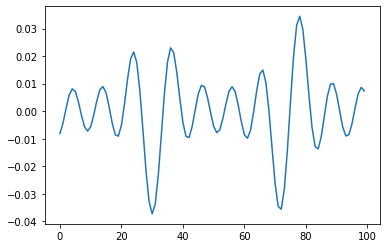

In [3]:
start = 500
n_pts = 100
plt.plot(X[int(start*rate/new_rate):int((start+n_pts)*rate/new_rate), 0])
plt.figure()
plt.plot(X_new_rate[start:start+n_pts, 0])
plt.figure()
plt.plot(Xds[start:start+n_pts, 0])
plt.figure()
plt.plot((X_new_rate - Xds)[start:start+n_pts, 0])
plt.figure()
plt.plot(Xds2[start:start+n_pts, 0])
plt.figure()
plt.plot((X_new_rate - Xds2)[start:start+n_pts, 0])

In [4]:
assert_allclose(X_new_rate, Xds)

NameError: name 'assert_allclose' is not defined

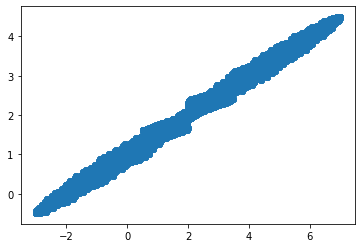

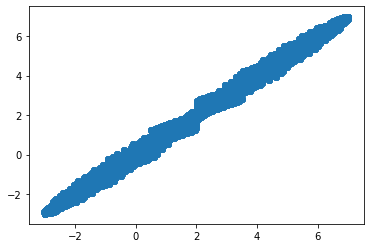

In [5]:
plt.scatter(X_new_rate.ravel(), Xds.ravel())
plt.figure()
plt.scatter(X_new_rate.ravel(), Xds2.ravel())

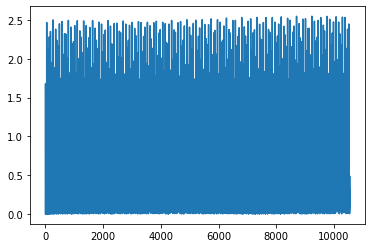

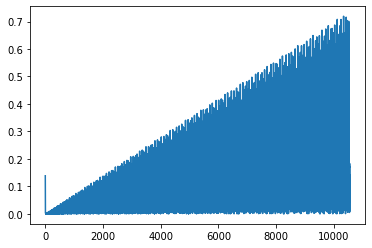

In [6]:
plt.plot(abs(X_new_rate[:, 0] -Xds[:, 0]))
plt.figure()
plt.plot(abs(X_new_rate[:, 0] -Xds2[:, 0]))

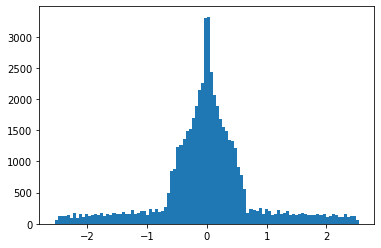

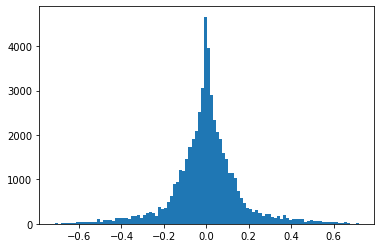

In [10]:
_ = plt.hist((X_new_rate-Xds).ravel(), bins=100)
plt.figure()
_ = plt.hist((X_new_rate-Xds2).ravel(), bins=100)

In [7]:
cosine(X_new_rate.ravel(), Xds.ravel())

0.04354496996772783